# TASK 1

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from matplotlib.font_manager import FontProperties
#from pandas_profiling import ProfileReport
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import os
from io import StringIO

In [2]:
data = pd.ExcelFile("2. Excel_Credit_Card_Data.xlsx")
data1 = pd.read_excel(data, 0)
data2 = pd.read_excel(data, 1)
df = data1.copy()

In [3]:
#We obtain year and month columns
df['YEAR'] = df['TRANSACTION_DATE'].dt.year
df['MONTH'] = df['TRANSACTION_DATE'].dt.month
df['QUARTER']=df['TRANSACTION_DATE'].dt.to_period('Q').dt.strftime('%qQ%y')
df.head(10)

,TRANSACTION_DATE,COMPANY,MERCHANT,TRANSACTION_COUNT,TRANSACTED_VALUE,YEAR,MONTH,QUARTER
0,2012-06-21,Arbys,Arbys,3825,37892.475210,2012,6,2Q12
1,2012-06-22,Arbys,Arbys,3884,39552.138593,2012,6,2Q12
2,2012-06-23,Arbys,Arbys,3113,36953.707410,2012,6,2Q12
3,2012-06-24,Arbys,Arbys,3457,38104.701896,2012,6,2Q12
4,2012-06-25,Arbys,Arbys,3480,34012.726002,2012,6,2Q12
5,2012-06-26,Arbys,Arbys,3801,37383.269400,2012,6,2Q12
6,2012-06-27,Arbys,Arbys,3645,35786.631696,2012,6,2Q12
7,2012-06-28,Arbys,Arbys,3923,36893.744528,2012,6,2Q12
8,2012-06-29,Arbys,Arbys,4074,41977.182743,2012,6,2Q12
9,2012-06-30,Arbys,Arbys,3152,38438.371058,2012,6,2Q12


In [4]:
#profile = ProfileReport(df.drop(['TRANSACTION_COUNT'], axis=1))
#profile.to_file("credit_card_profile.html")

In [5]:
data2.head()

,TRANSACTION_DATE,NORMALIZATION_FACTOR
0,2012-06-21,3728765
1,2012-06-22,4186954
2,2012-06-23,3685411
3,2012-06-24,3491099
4,2012-06-25,3915872


## Exploring the Dataset

In [6]:
df.loc[(df['MERCHANT']=='KFC') | (df['MERCHANT']=='TB/PH/KFC') | (df['MERCHANT']=='KFC/TB')]['COMPANY'].value_counts()

YUM-USAA    2318
Name: COMPANY, dtype: int64

In [11]:
df['MERCHANT'].value_counts()

Burger King        905
Auntie Annes       905
Orange Julius      905
Cinnabon           905
Hibachi San        905
Moes SW Grill      905
Qdoba              905
Popeyes            905
McAlisters Deli    905
Schlotzskys        905
Jack in the Box    905
White Castle       905
Taco Bell          905
Dominos Pizza      905
Arbys              905
El Pollo Loco      905
Dairy Queen        905
Tim Hortons        905
Sonic Drive In     905
McDonalds          905
Hardees            905
TB/PH              905
Chick-Fil-A        905
KFC                905
In-N-Out Burger    905
Carls Jr           905
Whataburger        905
KFC/TB             905
Quiznos            905
Subway Sandwich    905
Panda Express      905
Del Taco           905
Papa Johns         905
Carvel             905
Little Caesars     905
Wendys             905
Pizza Hut          905
Panda Inn          900
KFC/PH             898
TB/PH/KFC          508
Name: MERCHANT, dtype: int64

### Checking if there are duplicates among 'YUM' merchants (TB/PH/KFC)

In [12]:
df.loc[(df['MERCHANT']=='KFC') | (df['MERCHANT']=='TB/PH/KFC') | (df['MERCHANT']=='KFC/TB')].groupby(['TRANSACTED_VALUE','TRANSACTION_DATE'])

In [13]:
d=df.loc[(df['MERCHANT']=='KFC') | (df['MERCHANT']=='Taco Bell') | (df['MERCHANT']=='Pizza Hut')].groupby('MERCHANT').sum()['TRANSACTED_VALUE']
d/sum(d)

MERCHANT
KFC          0.202989
Pizza Hut    0.405022
Taco Bell    0.391989
Name: TRANSACTED_VALUE, dtype: float64

([<matplotlib.patches.Wedge at 0x2288d6dc108>,
 [Text(0.9239809565354733, 0.68465990970685, 'KFC'),
  Text(-0.9531694378538845, 0.6434034680830606, 'Pizza Hut'),
  Text(0.3827807886489214, -1.0844255935016056, 'Taco Bell')],
 [Text(0.5222501058678761, 0.3869816880951761, '20.3%'),
  Text(-0.5387479431348042, 0.3636628297860777, '40.5%'),
  Text(0.21635435880156426, -0.6129362050226467, '39.2%')])

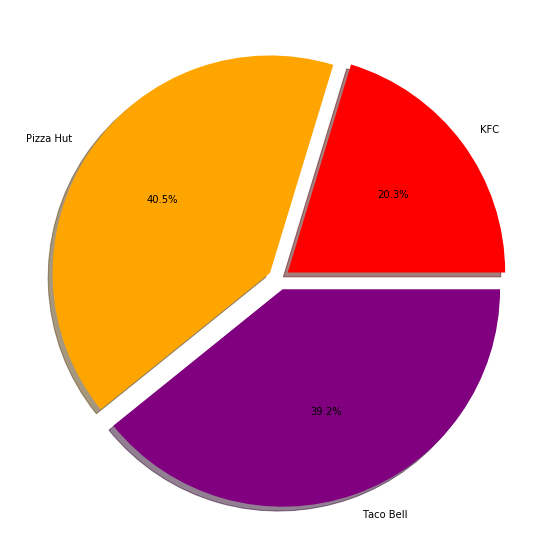

In [14]:
#This was done in case we tried estimating the Pizza Hut portion of the TB/PH and KFC/TB/PH merchants
plt.figure(figsize=(10,10))
plt.pie(x=d/sum(d), labels= ['KFC','Pizza Hut', 'Taco Bell'], autopct='%1.1f%%', colors=['red','orange', 'purple'], shadow=True, explode=[0.05,0.05,0.05])

## Q1 (a)

In [15]:
interest = ['McDonalds', 'Burger King', 'Wendys', 'Pizza Hut', 'Dominos Pizza', 'Papa Johns']
df[df['MERCHANT'].isin(interest)].groupby(['COMPANY', 'MERCHANT']).sum()

,,TRANSACTION_COUNT,TRANSACTED_VALUE,YEAR,MONTH
COMPANY,MERCHANT,,,,
DPZ-USAA,Dominos Pizza,9003350,2.172847e+08,1821917,6381
MCD-USAA,McDonalds,84270929,6.346821e+08,1821917,6381
PZZA-USAA,Papa Johns,7817713,1.912798e+08,1821917,6381
QSR-USAA,Burger King,15613789,1.376339e+08,1821917,6381
WEN-USAA,Wendys,19789854,1.850010e+08,1821917,6381
YUM-USAA,Pizza Hut,7317174,1.661743e+08,1821917,6381


In [16]:
df_1a = df[df['MERCHANT'].isin(interest)].groupby(['YEAR','MONTH', 'MERCHANT']).sum()['TRANSACTED_VALUE'].reset_index()
df_1a.loc[(df_1a['YEAR']==2014) & (df_1a['MONTH']>=10)]

,YEAR,MONTH,MERCHANT,TRANSACTED_VALUE
168,2014,10,Burger King,3.013600e+06
169,2014,10,Dominos Pizza,5.378195e+06
170,2014,10,McDonalds,1.341512e+07
171,2014,10,Papa Johns,4.765119e+06
172,2014,10,Pizza Hut,3.793275e+06
173,2014,10,Wendys,4.324123e+06
174,2014,11,Burger King,7.173364e+06
175,2014,11,Dominos Pizza,1.305084e+07
176,2014,11,McDonalds,3.243685e+07
177,2014,11,Papa Johns,1.148505e+07


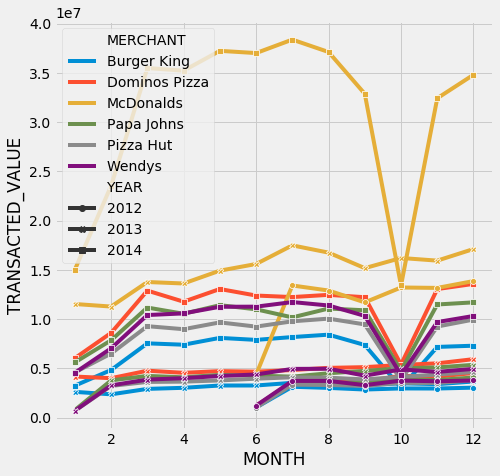

In [17]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,7))
g=sns.lineplot(x='MONTH', y='TRANSACTED_VALUE', hue='MERCHANT', style='YEAR', markers=True, dashes=False,data=df_1a)

<Figure size 504x288 with 0 Axes>

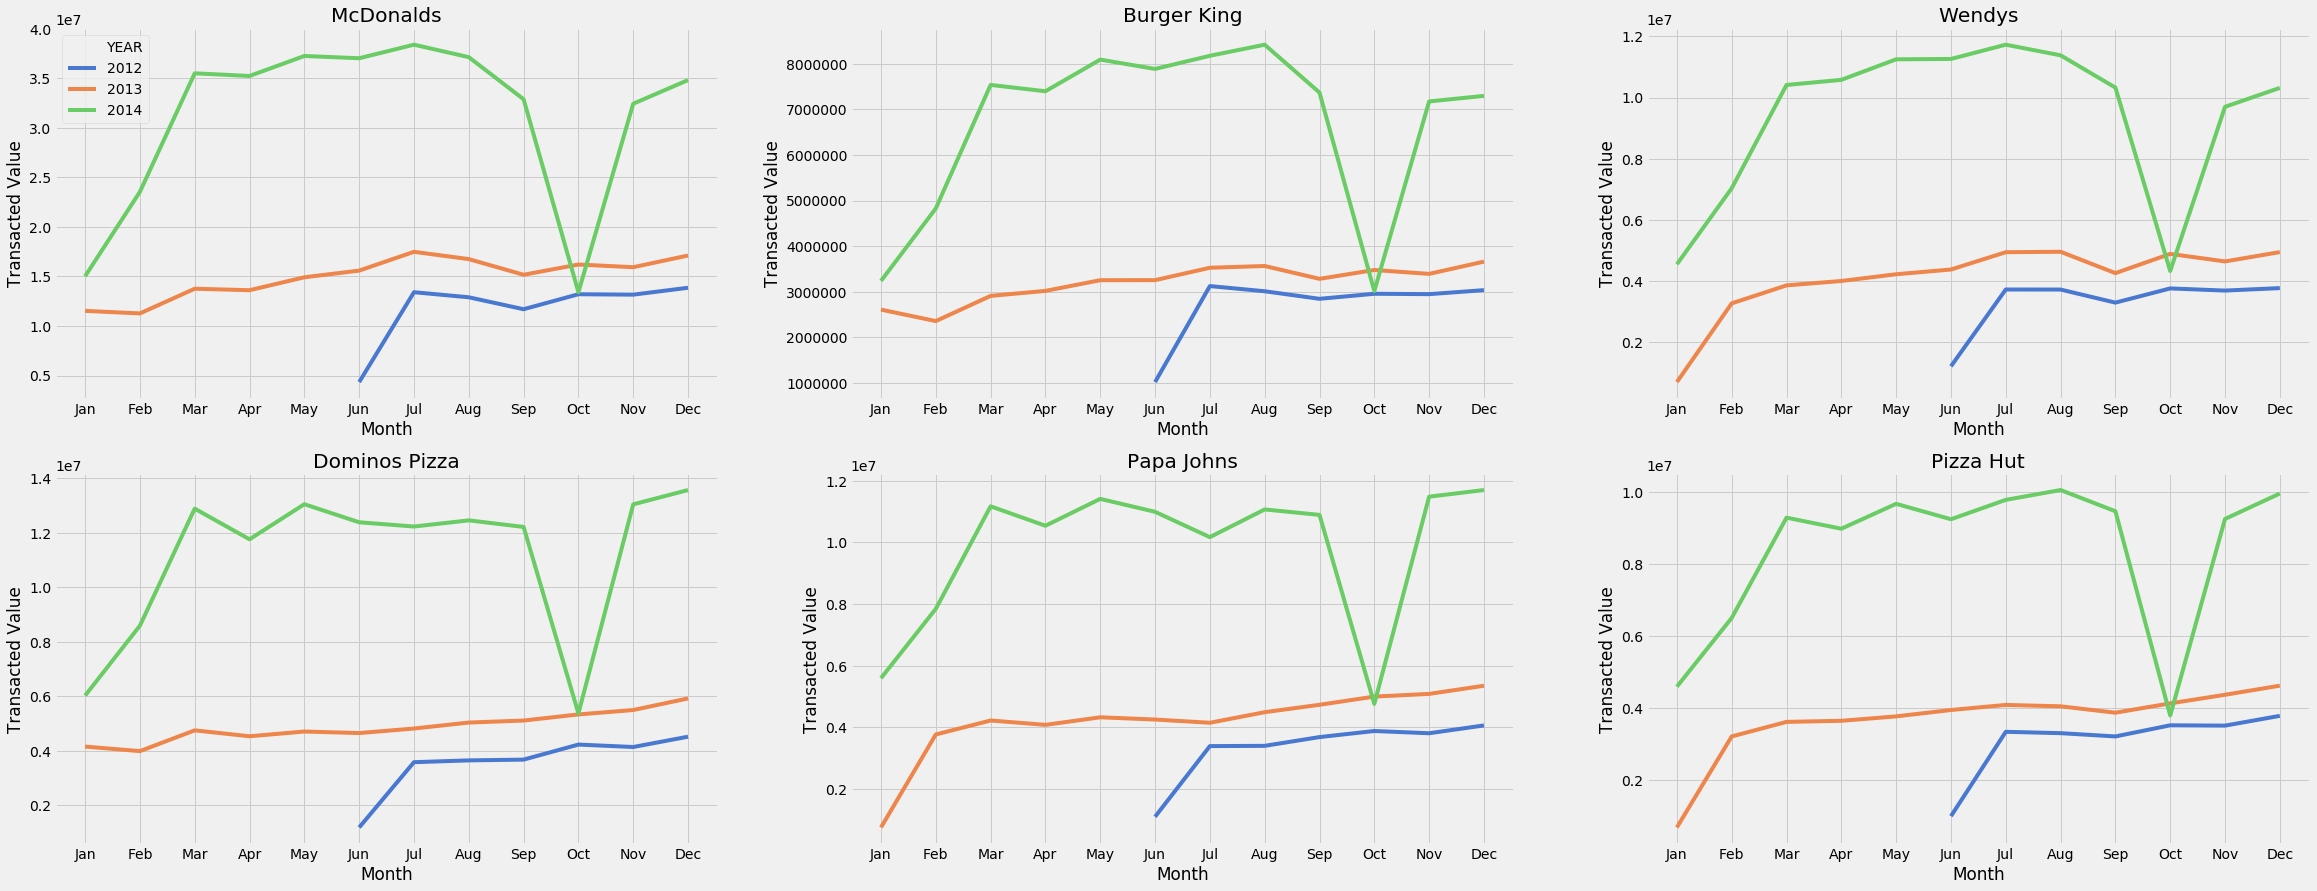

In [18]:
plt.figure(figsize=(7,4))
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(36,14))
sns.lineplot(ax=axes[0,0],data=df_1a.loc[(df_1a['MERCHANT']=='McDonalds')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR', palette='muted').set_title("McDonalds")
sns.lineplot(ax=axes[0,1],data=df_1a.loc[(df_1a['MERCHANT']=='Burger King')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Burger King")
sns.lineplot(ax=axes[0,2],data=df_1a.loc[(df_1a['MERCHANT']=='Wendys')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Wendys")
sns.lineplot(ax=axes[1,0],data=df_1a.loc[(df_1a['MERCHANT']=='Dominos Pizza')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Dominos Pizza")
sns.lineplot(ax=axes[1,1],data=df_1a.loc[(df_1a['MERCHANT']=='Papa Johns')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Papa Johns")
sns.lineplot(ax=axes[1,2],data=df_1a.loc[(df_1a['MERCHANT']=='Pizza Hut')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Pizza Hut")
plt.setp(axes, xticks=(range(1,13)), xticklabels=[calendar.month_abbr[(i)] for i in range(1,13)],ylabel='Transacted Value', xlabel='Month')
plt.savefig("agg_sales.png",transparent=True)

### Why the sudden drop in transacted value for the month of October 2014

In [19]:
# It appears we don't have all the transaction (dates missing) for the month of october
df.loc[(df['YEAR']==2014) & (df['MONTH']==10) & (df['MERCHANT']=='McDonalds')].count()

TRANSACTION_DATE     12
COMPANY              12
MERCHANT             12
TRANSACTION_COUNT    12
TRANSACTED_VALUE     12
YEAR                 12
MONTH                12
QUARTER              12
dtype: int64

In [20]:
df.loc[(df['YEAR']==2014) & (df['MONTH']==9) & (df['MERCHANT']=='McDonalds')].count()

TRANSACTION_DATE     30
COMPANY              30
MERCHANT             30
TRANSACTION_COUNT    30
TRANSACTED_VALUE     30
YEAR                 30
MONTH                30
QUARTER              30
dtype: int64

In [21]:
df.loc[(df['YEAR']==2014) & (df['MONTH']==10) & (df['MERCHANT']=='McDonalds')].TRANSACTION_DATE

18027   2014-10-26
18028   2014-10-26
18029   2014-10-27
18030   2014-10-27
18031   2014-10-28
18032   2014-10-28
18033   2014-10-29
18034   2014-10-29
18035   2014-10-30
18036   2014-10-30
18037   2014-10-31
18038   2014-10-31
Name: TRANSACTION_DATE, dtype: datetime64[ns]

In [22]:
#Those are the only dates in October 2014 which are then duplicated
df.loc[(df['YEAR']==2014) & (df['MONTH']==10)].TRANSACTION_DATE.unique()

array(['2014-10-26T00:00:00.000000000', '2014-10-27T00:00:00.000000000',
       '2014-10-28T00:00:00.000000000', '2014-10-29T00:00:00.000000000',
       '2014-10-30T00:00:00.000000000', '2014-10-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

#### It appears the 6 dates above are duplicated for a total number of 12 entries, therefore still not accounting for the missing dates of October

### Visualising the 3 months of 4Q14

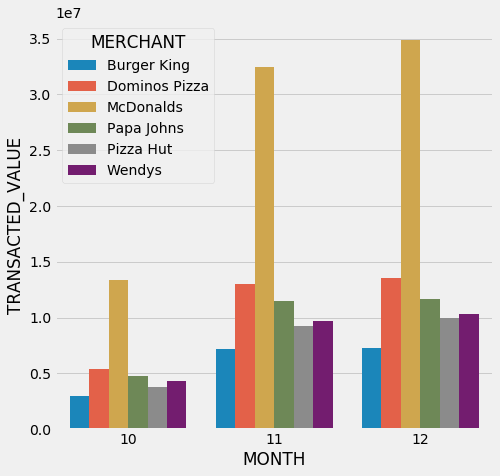

In [23]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,7))
sns.barplot(x='MONTH', y='TRANSACTED_VALUE', hue='MERCHANT',data=df_1a.loc[(df_1a['YEAR']==2014) & (df_1a['MONTH']>=10)])
plt.savefig("agg_sales_4q14.png",transparent=True)

## Q1 (b)

In [24]:
df.groupby(['TRANSACTION_DATE']).sum()['TRANSACTION_COUNT']

TRANSACTION_DATE
2012-06-21    204230
2012-06-22    215217
2012-06-23    188897
2012-06-24    179268
2012-06-25    194840
               ...  
2014-12-27    451109
2014-12-28    433348
2014-12-29    534851
2014-12-30    516041
2014-12-31    494715
Name: TRANSACTION_COUNT, Length: 899, dtype: int64

#### Total transaction count per date doesn't match normalization factor for the same date on sheet 2 (which is being understood as panel size or total transactions)

#### Assuming therefore that Sheet 1 is a sample taken out of a bigger population and sheet 2 are the stats for this larger population (hence equivalent values in sheet 1> sheet 2)

In [25]:
#6 dates are duplicated
data2[data2['TRANSACTION_DATE'].duplicated(keep=False)]['TRANSACTION_DATE'].unique()

array(['2014-10-26T00:00:00.000000000', '2014-10-27T00:00:00.000000000',
       '2014-10-28T00:00:00.000000000', '2014-10-29T00:00:00.000000000',
       '2014-10-30T00:00:00.000000000', '2014-10-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [26]:
#for a combined total of 12 times
data2[data2['TRANSACTION_DATE'].duplicated(keep=False)]['TRANSACTION_DATE'].count()

12

In [27]:
#Since the values
data2[data2['TRANSACTION_DATE'].duplicated(keep=False)]

,TRANSACTION_DATE,NORMALIZATION_FACTOR
832,2014-10-26,11354385
833,2014-10-26,11295760
834,2014-10-27,11756101
835,2014-10-27,11797289
836,2014-10-28,11410026
837,2014-10-28,11443158
838,2014-10-29,11135959
839,2014-10-29,11158306
840,2014-10-30,10856124
841,2014-10-30,10827402


In [28]:
data2.loc[data2['TRANSACTION_DATE']=='2014-10-25']

,TRANSACTION_DATE,NORMALIZATION_FACTOR


In [29]:
#All dates in sheet 1 have a match in sheet 2 and vice versa 
data2[~data2['TRANSACTION_DATE'].isin(df['TRANSACTION_DATE'])]
df[~df['TRANSACTION_DATE'].isin(data2['TRANSACTION_DATE'])]

,TRANSACTION_DATE,COMPANY,MERCHANT,TRANSACTION_COUNT,TRANSACTED_VALUE,YEAR,MONTH,QUARTER


#### We ruled out the hypothesis that some of the duplicates might have been dates present in sheet 1 but not sheet 2 (due to being mislabelled as an already present date)
#### We will assume that the dates are correct and truly simply duplicates - and since a singular value cannot be chosen - they shall be averaged per date
#### We also note that both sheets have the same dates duplicated and the same dates missing for Oct 2014

In [30]:
# averaging will leave non-duplicated values unchanged
df2 = data2.groupby(['TRANSACTION_DATE']).mean()
df2.head()

,NORMALIZATION_FACTOR
TRANSACTION_DATE,
2012-06-21,3728765.0
2012-06-22,4186954.0
2012-06-23,3685411.0
2012-06-24,3491099.0
2012-06-25,3915872.0


In [31]:
# A simple join will allows us to merge the tables
df_1b = df.join(df2, on= 'TRANSACTION_DATE', how='left')
df_1b = df_1b[df_1b['MERCHANT'].isin(interest)].groupby(['YEAR', 'MONTH', 'MERCHANT']).sum()
#We then divide by the normalization factor and multiply by 100 to get a normalized value
df_1b['NORMALIZED_VALUE']=df_1b['TRANSACTED_VALUE']/df_1b['NORMALIZATION_FACTOR']*100
df_1b=df_1b.reset_index()
df_1b.head()

,YEAR,MONTH,MERCHANT,TRANSACTION_COUNT,TRANSACTED_VALUE,NORMALIZATION_FACTOR,NORMALIZED_VALUE
0,2012,6,Burger King,114664,1.017541e+06,37693334.0,2.699525
1,2012,6,Dominos Pizza,49360,1.195164e+06,37693334.0,3.170758
2,2012,6,McDonalds,563475,4.344916e+06,37693334.0,11.527015
3,2012,6,Papa Johns,47591,1.105055e+06,37693334.0,2.931698
4,2012,6,Pizza Hut,45770,1.000628e+06,37693334.0,2.654654


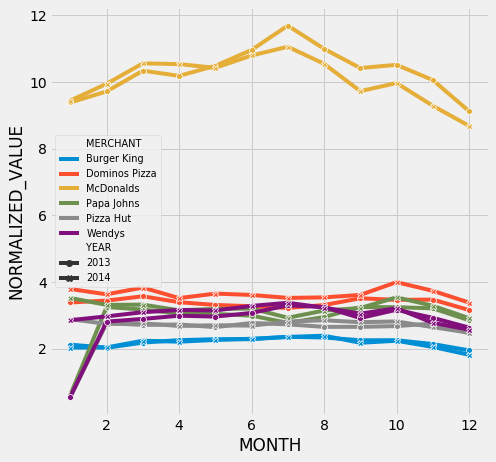

In [32]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,7))
g=sns.lineplot(x='MONTH', y='NORMALIZED_VALUE', hue='MERCHANT', style='YEAR', markers=True, dashes=False,data=df_1b.loc[df_1b['YEAR']>=2013])
g.legend(fontsize='x-small')

<Figure size 504x288 with 0 Axes>

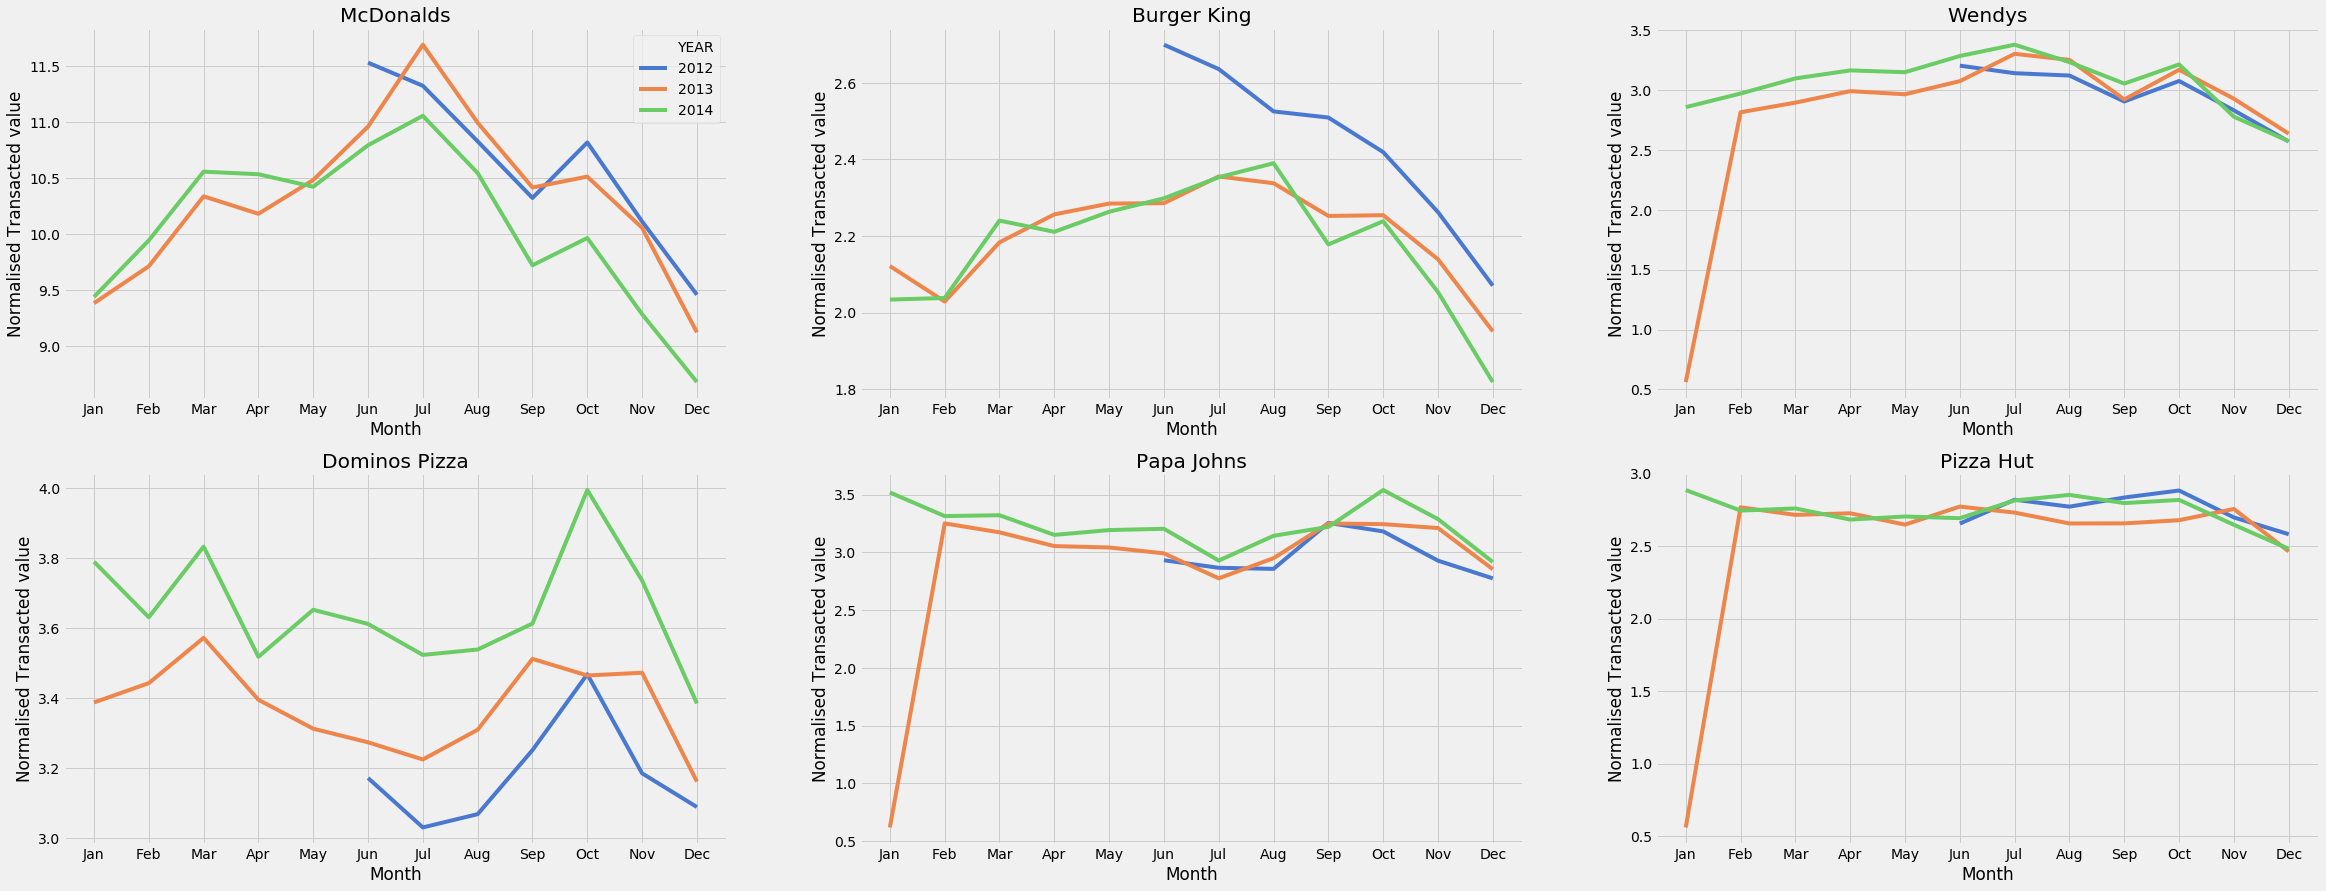

In [33]:
plt.figure(figsize=(7,4))
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(36,14))
sns.lineplot(ax=axes[0,0],data=df_1b.loc[(df_1b['MERCHANT']=='McDonalds')], x= 'MONTH', y='NORMALIZED_VALUE', hue='YEAR', palette='muted').set_title("McDonalds")
sns.lineplot(ax=axes[0,1],data=df_1b.loc[(df_1b['MERCHANT']=='Burger King')], x= 'MONTH', y='NORMALIZED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Burger King")
sns.lineplot(ax=axes[0,2],data=df_1b.loc[(df_1b['MERCHANT']=='Wendys')], x= 'MONTH', y='NORMALIZED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Wendys")
sns.lineplot(ax=axes[1,0],data=df_1b.loc[(df_1b['MERCHANT']=='Dominos Pizza')], x= 'MONTH', y='NORMALIZED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Dominos Pizza")
sns.lineplot(ax=axes[1,1],data=df_1b.loc[(df_1b['MERCHANT']=='Papa Johns')], x= 'MONTH', y='NORMALIZED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Papa Johns")
sns.lineplot(ax=axes[1,2],data=df_1b.loc[(df_1b['MERCHANT']=='Pizza Hut')], x= 'MONTH', y='NORMALIZED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Pizza Hut")
plt.setp(axes, xticks=(range(1,13)), xticklabels=[calendar.month_abbr[(i)] for i in range(1,13)],ylabel='Normalised Transacted value', xlabel='Month')
plt.savefig("normalised_sales.png",transparent=True)

### Visualising the last 3 months

In [34]:
t1=df_1b.loc[(df_1b['YEAR']==2014) & (df_1b['MONTH']>=10)]
t1.loc[t1['MONTH']==10, 'MONTH'] = 'October'
t1.loc[t1['MONTH']==11, 'MONTH'] = 'November'
t1.loc[t1['MONTH']==12, 'MONTH'] = 'December'
t1.pivot('MONTH','MERCHANT','NORMALIZED_VALUE')

C:\Users\ddkya\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


MERCHANT,Burger King,Dominos Pizza,McDonalds,Papa Johns,Pizza Hut,Wendys
MONTH,,,,,,
December,1.818530,3.384172,8.681254,2.916575,2.480315,2.571632
November,2.053521,3.736067,9.285705,3.287828,2.646270,2.775883
October,2.238549,3.995006,9.964958,3.539604,2.817703,3.212025


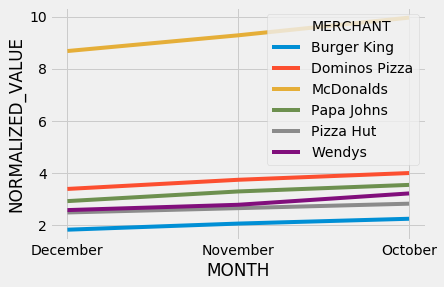

In [35]:
plt.style.use('fivethirtyeight')
g = sns.lineplot(data=t1, x= 'MONTH', y='NORMALIZED_VALUE', hue='MERCHANT')

## Q1 (c)

In [36]:
#We create another dataset where the values are shifted by 12 months to calculate YoY
df_1c=df[df['MERCHANT'].isin(interest)].groupby(['YEAR', 'MONTH', 'MERCHANT']).sum()
df1_1c=df_1c.copy()
df2_1c=df_1c.shift(12)

In [37]:
#using the normal and shifted datasets to calculate the yoy difference then dividing by the previous year's value and multiplying by 100 for a percentage growth
df3_1c=((df1_1c['TRANSACTED_VALUE']-df2_1c['TRANSACTED_VALUE'])/df2_1c['TRANSACTED_VALUE'])*100
df3_1c=df3_1c[13:].reset_index()
df3_1c['M-Y']=df3_1c['MONTH'].astype(str)+'-'+df3_1c['YEAR'].astype(str)
df3_1c

,YEAR,MONTH,MERCHANT,TRANSACTED_VALUE,M-Y
0,2012,8,Dominos Pizza,205.850219,8-2012
1,2012,8,McDonalds,196.940012,8-2012
2,2012,8,Papa Johns,208.113423,8-2012
3,2012,8,Pizza Hut,230.060855,8-2012
4,2012,8,Wendys,208.021226,8-2012
...,...,...,...,...,...
168,2014,12,Dominos Pizza,152.422598,12-2014
169,2014,12,McDonalds,159.597329,12-2014
170,2014,12,Papa Johns,145.534042,12-2014
171,2014,12,Pizza Hut,162.303973,12-2014


<Figure size 504x288 with 0 Axes>

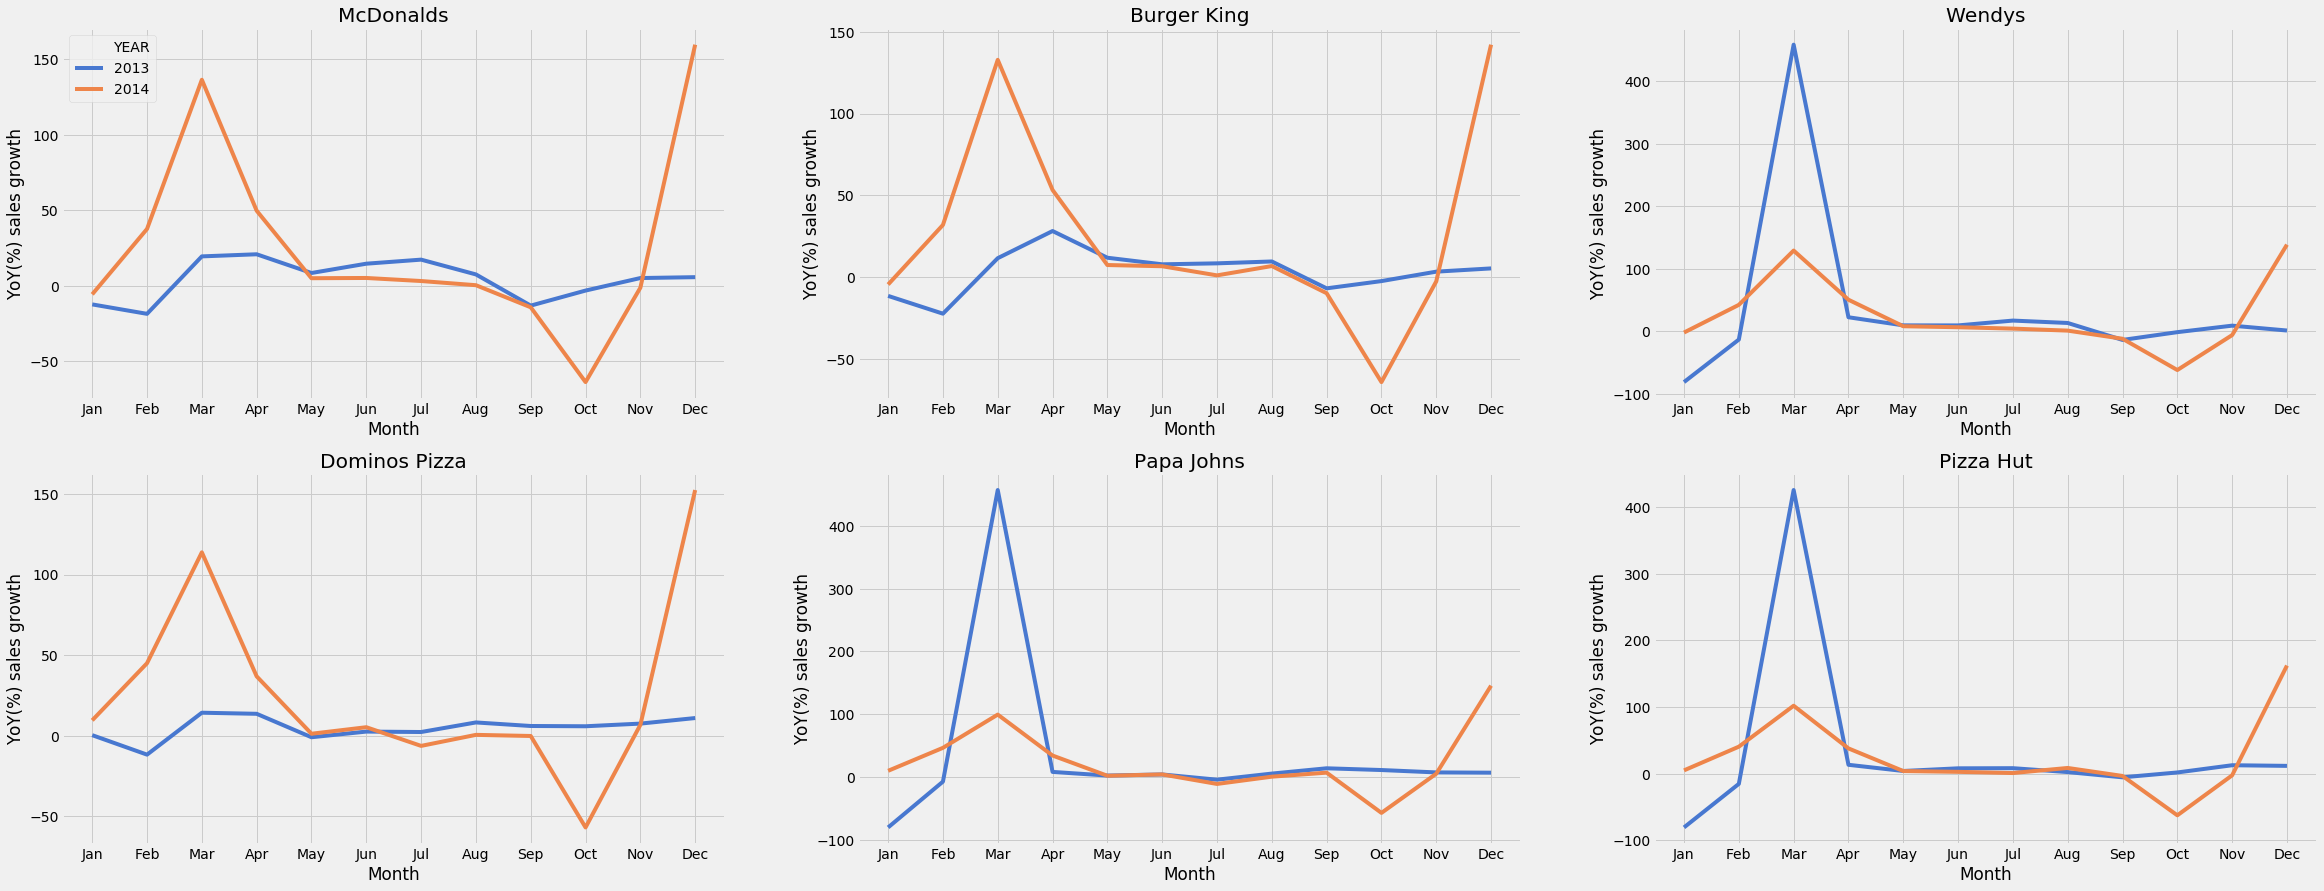

In [38]:
plt.figure(figsize=(7,4))
plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(36,14))
sns.lineplot(ax=axes[0,0],data=df3_1c.loc[(df3_1c['YEAR']>2012) & (df3_1c['MERCHANT']=='McDonalds')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR', palette='muted').set_title("McDonalds")
sns.lineplot(ax=axes[0,1],data=df3_1c.loc[(df3_1c['YEAR']>2012) & (df3_1c['MERCHANT']=='Burger King')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Burger King")
sns.lineplot(ax=axes[0,2],data=df3_1c.loc[(df3_1c['YEAR']>2012) & (df3_1c['MERCHANT']=='Wendys')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Wendys")
sns.lineplot(ax=axes[1,0],data=df3_1c.loc[(df3_1c['YEAR']>2012) & (df3_1c['MERCHANT']=='Dominos Pizza')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Dominos Pizza")
sns.lineplot(ax=axes[1,1],data=df3_1c.loc[(df3_1c['YEAR']>2012) & (df3_1c['MERCHANT']=='Papa Johns')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Papa Johns")
sns.lineplot(ax=axes[1,2],data=df3_1c.loc[(df3_1c['YEAR']>2012) & (df3_1c['MERCHANT']=='Pizza Hut')], x= 'MONTH', y='TRANSACTED_VALUE', hue='YEAR',legend=False, palette='muted').set_title("Pizza Hut")
plt.setp(axes, xticks=(range(1,13)), xticklabels=[calendar.month_abbr[(i)] for i in range(1,13)],ylabel='YoY(%) sales growth', xlabel='Month')
plt.savefig("yoy_sales.png",transparent=True)

[Text(0, 0.5, 'YoY(%) sales growth'), Text(0.5, 0, 'Month')]

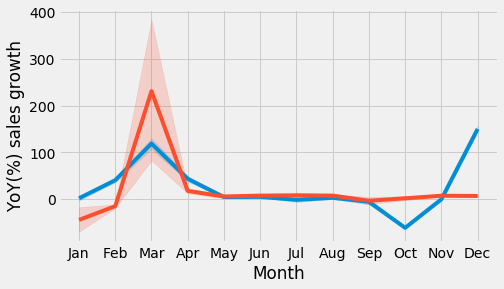

In [39]:
plt.figure(figsize=(7,4))
plt.style.use('fivethirtyeight')
g =sns.lineplot(data=df3_1c.loc[(df3_1c['YEAR']==2014)], x= 'MONTH', y='TRANSACTED_VALUE')
sns.lineplot(data=df3_1c.loc[(df3_1c['YEAR']==2013)], x= 'MONTH', y='TRANSACTED_VALUE')
plt.xticks(range(1,13))
g.set_xticklabels([calendar.month_abbr[(i)] for i in range(1,13)])
g.set_xticklabels([calendar.month_abbr[(i)] for i in range(1,13)])
g.set(xlabel='Month', ylabel='YoY(%) sales growth')

## Q2

### URL Data

In [40]:
url=pd.ExcelFile("5. URL Data2.xlsx")

In [41]:
#Preparing the URL dataset for later
url_df = pd.read_excel(url, skiprows=[1,2,3,4,5,7,8,9,10], header=[1])
url_columns=url_df.columns.to_list()
url_columns[0]='Merchant'
url_columns[1]='Metric'
url_columns = [x.strip(' ') for x in url_columns]
url_df.columns = url_columns
url_df['Metric']=url_df['Metric'].str.strip()
url_df=url_df.set_index(['Merchant', 'Metric']).T
url_df.index = url_df.index.set_names(['QUARTER'])
url_df.head(10)

Merchant        Dominos Pizza                         \
Metric   Total Unique Viewers     Reach Total Visits   
QUARTER                                                
1Q13                   8211.0  0.008211      73899.0   
2Q13                   7348.0  0.007348      58784.0   
3Q13                   8430.0  0.008430      59010.0   
4Q13                   8512.0  0.008512      68096.0   
1Q14                   8874.0  0.008874      79866.0   
2Q14                   9354.0  0.009354      84186.0   
3Q14                   9355.0  0.009355      93550.0   
4Q14                   9745.0  0.009745      97450.0   

Merchant                                                         \
Metric   Average Visits per Unique Visitor/Viewer Total Minutes   
QUARTER                                                           
1Q13                                          9.0      413834.4   
2Q13                                          8.0      329190.4   
3Q13                                          7.0      330456.0   
4Q13                                          8.0      381337.6   
1Q14                                          9.0      399330.0   
2Q14                                          9.0      420930.0   
3Q14                                         10.0      374200.0   
4Q14                                         10.0      389800.0   

Merchant                                     Papa Johns            \
Metric   Average Minutes per Visit Total Unique Viewers     Reach   
QUARTER                                                             
1Q13                           5.6              7212.00  0.007212   
2Q13                           5.6              6542.00  0.006542   
3Q13                           5.6              7125.00  0.007125   
4Q13                           5.6              7111.10  0.007111   
1Q14                           5.0              7257.00  0.007257   
2Q14                           5.0              7421.58  0.007422   
3Q14                           4.0              7631.50  0.007632   
4Q14                           4.0              7901.00  0.007901   

Merchant                                                        ...  \
Metric   Total Visits Average Visits per Unique Visitor/Viewer  ...   
QUARTER                                                         ...   
1Q13         50484.00                                      7.0  ...   
2Q13         45794.00                                      7.0  ...   
3Q13         57000.00                                      8.0  ...   
4Q13         63999.90                                      9.0  ...   
1Q14         58056.00                                      8.0  ...   
2Q14         66794.22                                      9.0  ...   
3Q14         83946.50                                     11.0  ...   
4Q14         79010.00                                     10.0  ...   

Merchant    Taco Bell                                                         \
Metric   Total Visits Average Visits per Unique Visitor/Viewer Total Minutes   
QUARTER                                                                        
1Q13          10680.0                                      4.0      34176.00   
2Q13          13394.5                                      5.0      44201.85   
3Q13          12415.0                                      5.0      40969.50   
4Q13          14880.0                                      6.0      44640.00   
1Q14          12415.0                                      5.0      42211.00   
2Q14          16413.6                                      7.0      52523.52   
3Q14          14502.0                                      6.0      44956.20   
4Q14           4292.0                                      2.0      13305.20   

Merchant                                        Popeyes            \
Metric   Average Minutes per Visit Total Unique Viewers     Reach   
QUARTER                                                             
1Q13           

### Survey Data

In [42]:
survey_df = pd.read_excel("4. Survey Results.xlsx", header=1, usecols = "C:K", skiprows=[1,2,3,4])
survey_df = survey_df.set_index(['Question:']).T
survey_df.columns = ['Visits', 'Dollars Spent', 'Promotions', 'App (Yes)','App (No)']
survey_df.index = survey_df.index.set_names(['QUARTER'])
survey_df.head(10)

,Visits,Dollars Spent,Promotions,App (Yes),App (No)
QUARTER,,,,,
1Q13,7.0,25.0,3.0,0.12,0.88
2Q13,5.0,25.0,4.0,0.14,0.86
3Q13,3.0,25.0,2.0,0.23,0.77
4Q13,4.0,15.0,6.0,0.32,0.68
1Q14,7.0,15.0,4.0,0.54,0.46
2Q14,8.0,25.0,7.0,0.66,0.34
3Q14,2.0,20.0,2.0,0.62,0.38
4Q14,3.0,30.0,3.0,0.71,0.29


In [43]:
#survey_profile = ProfileReport(survey_df)
#survey_profile.to_file("survey_profile.html")

### Credit Card Data (with Quarters as index)

In [44]:
credit_df = df[df['MERCHANT'].isin(interest)].groupby(['MERCHANT', 'QUARTER']).sum()['TRANSACTED_VALUE']
credit_df=credit_df.unstack().T
credit_df

MERCHANT,Burger King,Dominos Pizza,McDonalds,Papa Johns,Pizza Hut,Wendys
QUARTER,,,,,,
1Q13,7.870378e+06,1.291525e+07,3.657289e+07,8.758823e+06,7.515178e+06,7.809261e+06
1Q14,1.559886e+07,2.752258e+07,7.407578e+07,2.462023e+07,2.037083e+07,2.198772e+07
2Q12,1.017541e+06,1.195164e+06,4.344916e+06,1.105055e+06,1.000628e+06,1.206916e+06
2Q13,9.523240e+06,1.391299e+07,4.413296e+07,1.267280e+07,1.135881e+07,1.258903e+07
2Q14,2.337299e+07,3.721663e+07,1.095180e+08,3.294936e+07,2.787337e+07,3.309244e+07
3Q12,8.976620e+06,1.092862e+07,3.801388e+07,1.048970e+07,9.854991e+06,1.072660e+07
3Q13,1.037068e+07,1.498541e+07,4.942090e+07,1.338488e+07,1.200341e+07,1.414821e+07
3Q14,2.396005e+07,3.692206e+07,1.084180e+08,3.213834e+07,2.927779e+07,3.343611e+07
4Q12,8.934705e+06,1.290691e+07,4.024191e+07,1.176515e+07,1.081582e+07,1.120312e+07


### Credit Card X URL Data

In [45]:
#Combining the URL and credit card data for analysis
credit_url_dom = pd.merge(credit_df['Dominos Pizza'].reset_index(),url_df['Dominos Pizza'].reset_index())
credit_url_dom.rename(columns={'Dominos Pizza':'Credit Card Spending'}, inplace=True)
credit_url_dom.head(10)

,QUARTER,Credit Card Spending,Total Unique Viewers,Reach,Total Visits,Average Visits per Unique Visitor/Viewer,Total Minutes,Average Minutes per Visit
0,1Q13,1.291525e+07,8211.0,0.008211,73899.0,9.0,413834.4,5.6
1,1Q14,2.752258e+07,8874.0,0.008874,79866.0,9.0,399330.0,5.0
2,2Q13,1.391299e+07,7348.0,0.007348,58784.0,8.0,329190.4,5.6
3,2Q14,3.721663e+07,9354.0,0.009354,84186.0,9.0,420930.0,5.0
4,3Q13,1.498541e+07,8430.0,0.008430,59010.0,7.0,330456.0,5.6
5,3Q14,3.692206e+07,9355.0,0.009355,93550.0,10.0,374200.0,4.0
6,4Q13,1.677429e+07,8512.0,0.008512,68096.0,8.0,381337.6,5.6
7,4Q14,3.200481e+07,9745.0,0.009745,97450.0,10.0,389800.0,4.0


In [46]:
#credit_url_profile = ProfileReport(credit_url_dom)
#credit_url_profile.to_file("credit_url_profile.html")

In [47]:
#The explicit correlation is displayed here clearly showing that internet traffic is correlated to credit card spending
print("Correlation - credit card spending & Unique viewers:",credit_url_dom['Credit Card Spending'].corr(credit_url_dom['Total Unique Viewers']))
print("Correlation - credit card spending & avg visit per visitor:",credit_url_dom['Credit Card Spending'].corr(credit_url_dom['Average Visits per Unique Visitor/Viewer']))
print("Correlation - credit card spending & time per visit:",credit_url_dom['Credit Card Spending'].corr(credit_url_dom['Average Minutes per Visit']))

Correlation - credit card spending & Unique viewers: 0.8623081852386272
Correlation - credit card spending & avg visit per visitor: 0.7382977485736154
Correlation - credit card spending & time per visit: -0.8420726025625067


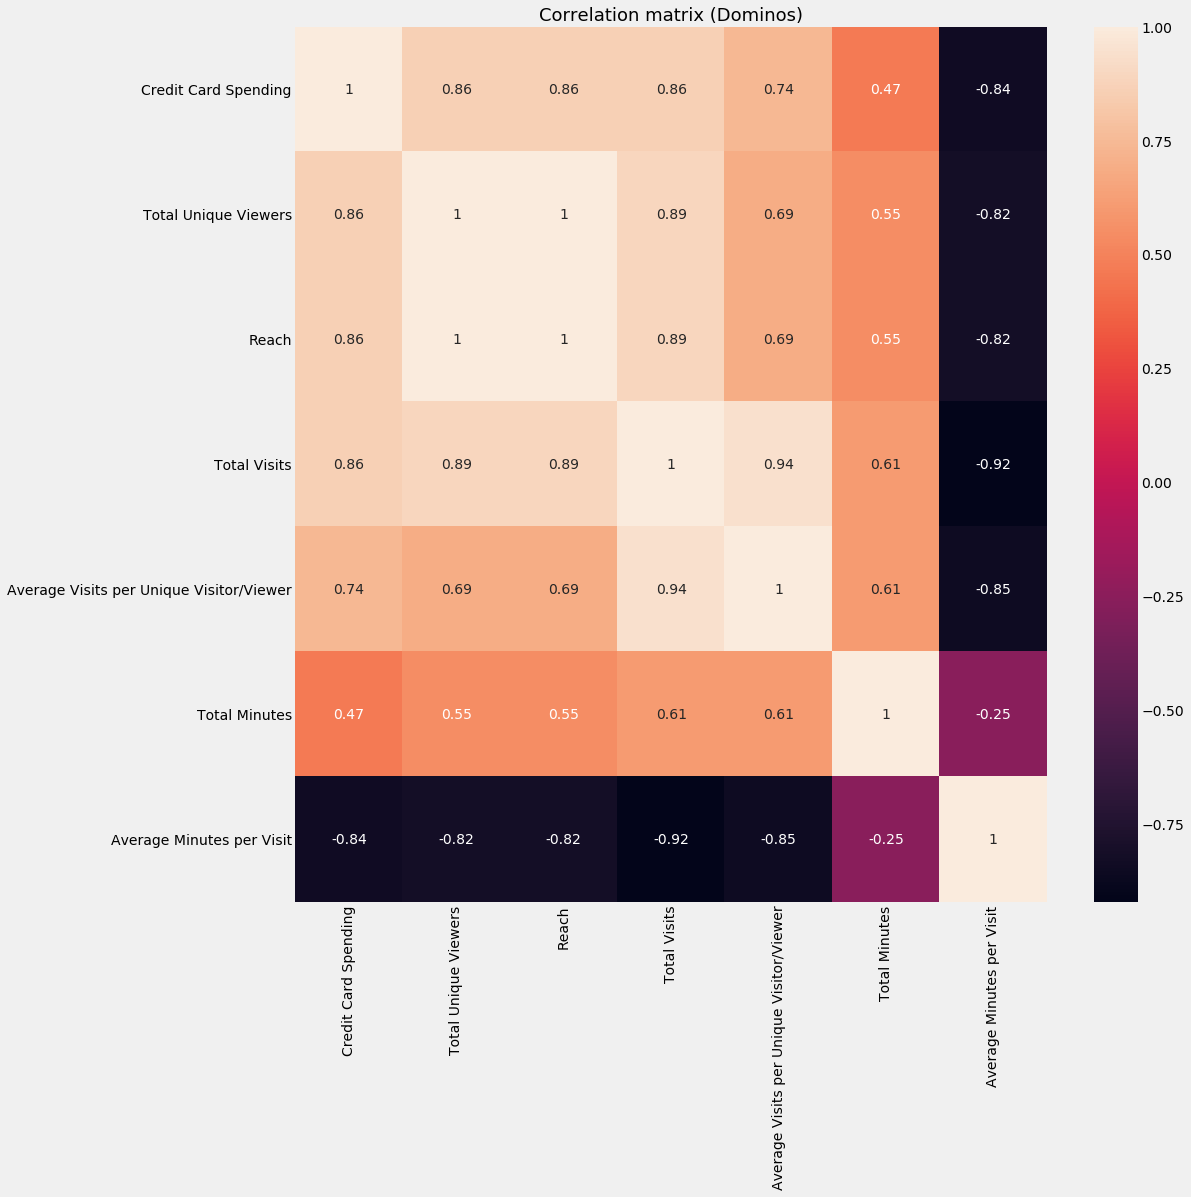

In [48]:
plt.figure(figsize=(15,15))
sns.heatmap(credit_url_dom.corr(), annot=True)
plt.title("Correlation matrix (Dominos)", fontsize=18)
plt.savefig("Correlation matrix (Dominos).png",transparent=True)

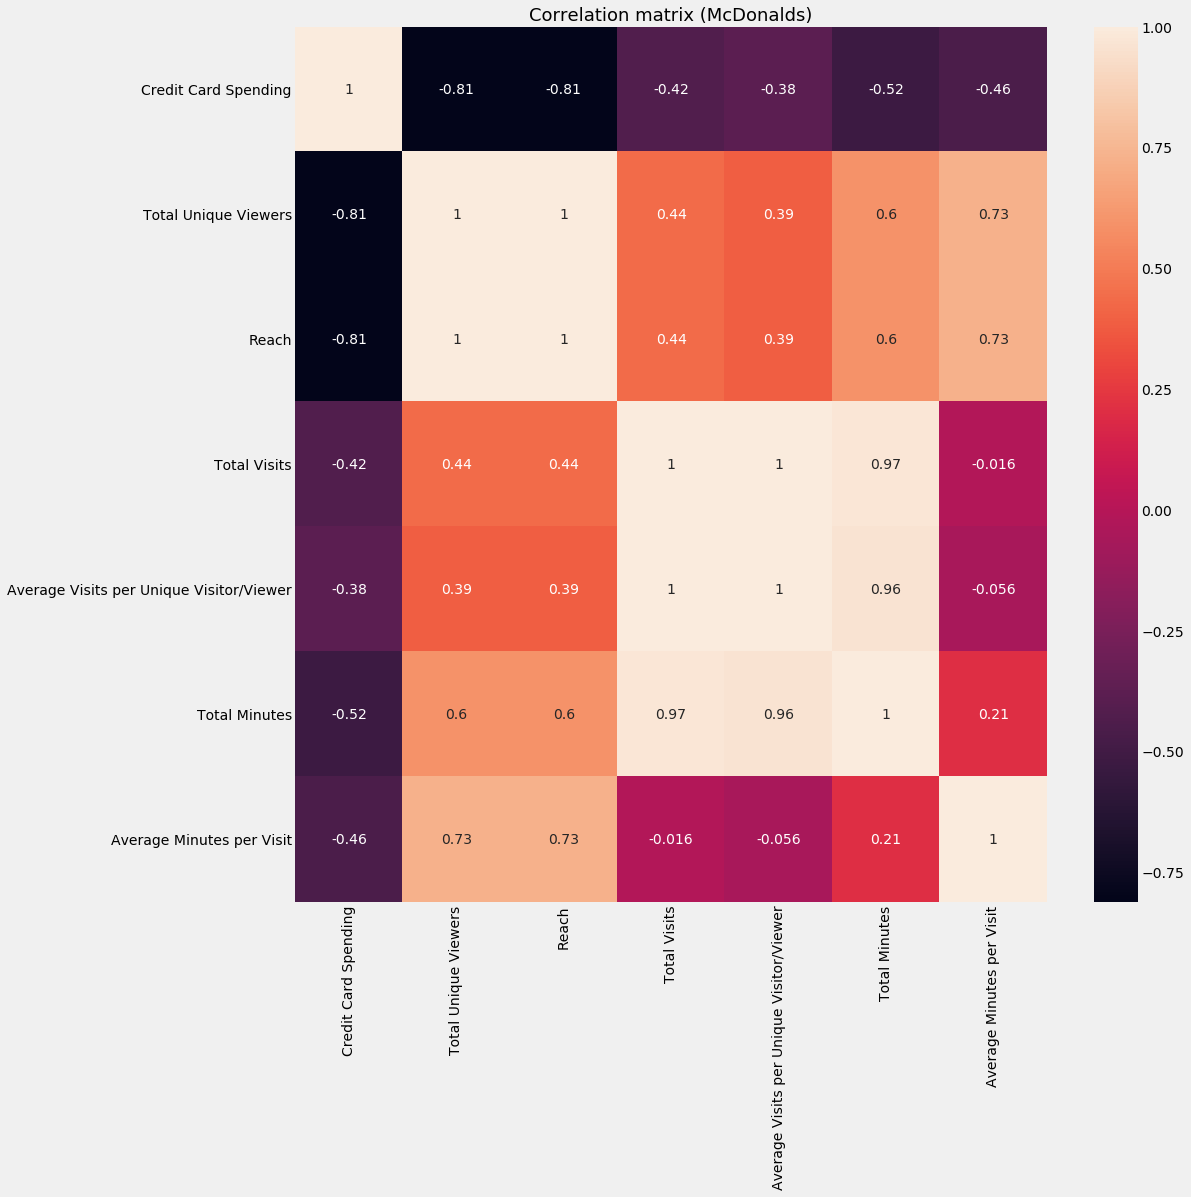

In [49]:
credit_url_mc = pd.merge(credit_df['McDonalds'].reset_index(),url_df['McDonalds'].reset_index())
credit_url_mc.rename(columns={'McDonalds':'Credit Card Spending'}, inplace=True)
plt.figure(figsize=(15,15))
sns.heatmap(credit_url_mc.corr(), annot=True)
plt.title("Correlation matrix (McDonalds)", fontsize=18)
plt.savefig("Correlation matrix (McDonalds).png",transparent=True)

### Credit Card X Survey Data

In [50]:
credit_survey = pd.merge(credit_df.reset_index(),survey_df.reset_index())
credit_survey.head()

,QUARTER,Burger King,Dominos Pizza,McDonalds,Papa Johns,Pizza Hut,Wendys,Visits,Dollars Spent,Promotions,App (Yes),App (No)
0,1Q13,7.870378e+06,1.291525e+07,3.657289e+07,8.758823e+06,7.515178e+06,7.809261e+06,7.0,25.0,3.0,0.12,0.88
1,1Q14,1.559886e+07,2.752258e+07,7.407578e+07,2.462023e+07,2.037083e+07,2.198772e+07,7.0,15.0,4.0,0.54,0.46
2,2Q13,9.523240e+06,1.391299e+07,4.413296e+07,1.267280e+07,1.135881e+07,1.258903e+07,5.0,25.0,4.0,0.14,0.86
3,2Q14,2.337299e+07,3.721663e+07,1.095180e+08,3.294936e+07,2.787337e+07,3.309244e+07,8.0,25.0,7.0,0.66,0.34
4,3Q13,1.037068e+07,1.498541e+07,4.942090e+07,1.338488e+07,1.200341e+07,1.414821e+07,3.0,25.0,2.0,0.23,0.77


Text(0.5, 1, 'Correlation matrix (CC & Survey)')

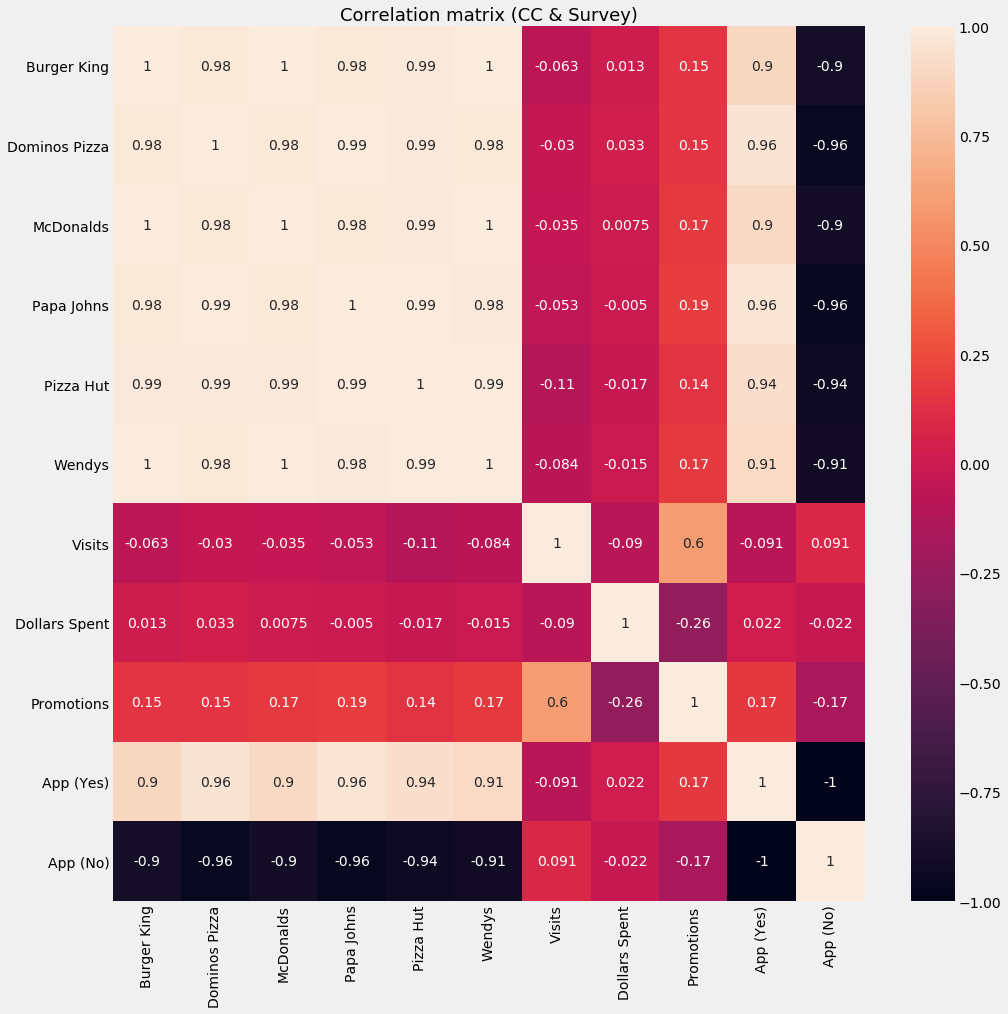

In [51]:
plt.figure(figsize=(15,15))
sns.heatmap(credit_survey.corr(), annot=True)
plt.title("Correlation matrix (CC & Survey)", fontsize=18)

# TASK 2

In [52]:
model_data = pd.ExcelFile("7. Modelling_test_data.xlsx")

In [53]:
price_df = pd.read_excel(model_data, 1)
price_df.head()

,Date,Close Price
0,2012-06-21,87.64
1,2012-06-22,88.35
2,2012-06-23,0.00
3,2012-06-24,0.00
4,2012-06-25,88.12


In [54]:
credit_df2 = df.loc[df['MERCHANT']=='McDonalds'].set_index('TRANSACTION_DATE')[['TRANSACTED_VALUE', 'QUARTER']]
credit_df2 = pd.DataFrame(credit_df2)

In [55]:
#normalising the above
credit_df2_norm = credit_df2.join(df2, on='TRANSACTION_DATE', how='left')
credit_df2_norm['NORMALIZED_VALUE']=credit_df2_norm['TRANSACTED_VALUE']/credit_df2_norm['NORMALIZATION_FACTOR']*100
credit_df2_norm.index = credit_df2_norm.index.set_names(['Date'])
credit_df2_norm

,TRANSACTED_VALUE,QUARTER,NORMALIZATION_FACTOR,NORMALIZED_VALUE
Date,,,,
2012-06-21,4.136718e+05,2Q12,3728765.0,11.094071
2012-06-22,4.556815e+05,2Q12,4186954.0,10.883365
2012-06-23,4.612457e+05,2Q12,3685411.0,12.515448
2012-06-24,4.580269e+05,2Q12,3491099.0,13.119848
2012-06-25,3.831620e+05,2Q12,3915872.0,9.784845
...,...,...,...,...
2014-12-27,1.158948e+06,4Q14,10376498.0,11.168971
2014-12-28,1.196732e+06,4Q14,10479593.0,11.419643
2014-12-29,1.167848e+06,4Q14,12118902.0,9.636586


In [56]:
price_cc = price_df.join(credit_df2_norm, on='Date', how='left')

In [57]:
price_cc['Close Price'].corr(price_cc['NORMALIZED_VALUE'])

-0.6290689939529606

In [58]:
price_cc_nowkd2 = price_cc.drop(price_cc[price_cc['Close Price'] == 0].index)
price_cc_nowkd2

,Date,Close Price,TRANSACTED_VALUE,QUARTER,NORMALIZATION_FACTOR,NORMALIZED_VALUE
0,2012-06-21,87.64,4.136718e+05,2Q12,3728765.0,11.094071
1,2012-06-22,88.35,4.556815e+05,2Q12,4186954.0,10.883365
4,2012-06-25,88.12,3.831620e+05,2Q12,3915872.0,9.784845
5,2012-06-26,89.10,3.883960e+05,2Q12,3918668.0,9.911430
6,2012-06-27,88.33,4.107806e+05,2Q12,3758891.0,10.928240
...,...,...,...,...,...,...
898,2014-12-25,93.83,5.264631e+05,4Q14,4671001.0,11.270884
899,2014-12-26,94.78,1.156501e+06,4Q14,11903179.0,9.715903
902,2014-12-29,95.04,1.167848e+06,4Q14,12118902.0,9.636586
903,2014-12-30,94.25,1.131268e+06,4Q14,11571844.0,9.776035


In [59]:
price_cc_nowkd2['Close Price'].corr(price_cc_nowkd2['NORMALIZED_VALUE'])

0.0995161964410637

## LSTM on share price

In [60]:
#random seed for reproducability
np.random.seed(47)

In [252]:
time_step = 1
X = price_cc_nowkd2['NORMALIZED_VALUE'].values
Y = price_cc_nowkd2['Close Price'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=47)
x_train = x_train.reshape(x_train.shape[0], time_step, 1)
x_test = x_test.reshape(x_test.shape[0], time_step, 1)

In [62]:
x_train.shape

(525, 1, 1)

In [63]:
#We build a simple LSTM neural network to try to predict share price
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_step,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, epochs=375, validation_data=(x_test, y_test))

Epoch 1/375
17/17 [==============================] - 14s 44ms/step - loss: 9140.2206 - val_loss: 9088.8535
Epoch 2/375
17/17 [==============================] - 0s 2ms/step - loss: 9146.8421 - val_loss: 9012.9375
Epoch 3/375
17/17 [==============================] - 0s 2ms/step - loss: 9049.2419 - val_loss: 8931.4502
Epoch 4/375
17/17 [==============================] - 0s 2ms/step - loss: 8916.3629 - val_loss: 8825.4795
Epoch 5/375
17/17 [==============================] - 0s 3ms/step - loss: 8795.2814 - val_loss: 8679.1963
Epoch 6/375
17/17 [==============================] - 0s 2ms/step - loss: 8625.2343 - val_loss: 8479.6211
Epoch 7/375
17/17 [==============================] - 0s 2ms/step - loss: 8416.3069 - val_loss: 8219.3398
Epoch 8/375
17/17 [==============================] - 0s 2ms/step - loss: 8114.2948 - val_loss: 7898.5713
Epoch 9/375
17/17 [==============================] - 0s 2ms/step - loss: 7871.2204 - val_loss: 7523.4351
Epoch 10/375
17/17 [==============================] -

17/17 [==============================] - 0s 2ms/step - loss: 100.7125 - val_loss: 110.2909
Epoch 158/375
17/17 [==============================] - 0s 2ms/step - loss: 109.4062 - val_loss: 110.1673
Epoch 159/375
17/17 [==============================] - 0s 2ms/step - loss: 99.3144 - val_loss: 109.9071
Epoch 160/375
17/17 [==============================] - 0s 2ms/step - loss: 105.3788 - val_loss: 109.7330
Epoch 161/375
17/17 [==============================] - 0s 2ms/step - loss: 96.0790 - val_loss: 109.5781
Epoch 162/375
17/17 [==============================] - 0s 2ms/step - loss: 103.2356 - val_loss: 109.6951
Epoch 163/375
17/17 [==============================] - 0s 2ms/step - loss: 107.2120 - val_loss: 109.4670
Epoch 164/375
17/17 [==============================] - 0s 2ms/step - loss: 102.9775 - val_loss: 109.1863
Epoch 165/375
17/17 [==============================] - 0s 2ms/step - loss: 100.2261 - val_loss: 109.5610
Epoch 166/375
17/17 [==============================] - 0s 2ms/step - lo

Epoch 236/375
17/17 [==============================] - 0s 2ms/step - loss: 81.1231 - val_loss: 91.3832
Epoch 237/375
17/17 [==============================] - 0s 2ms/step - loss: 75.8799 - val_loss: 90.8407
Epoch 238/375
17/17 [==============================] - 0s 2ms/step - loss: 78.4455 - val_loss: 89.4157
Epoch 239/375
17/17 [==============================] - 0s 2ms/step - loss: 79.1255 - val_loss: 89.1252
Epoch 240/375
17/17 [==============================] - 0s 2ms/step - loss: 80.1083 - val_loss: 88.3121
Epoch 241/375
17/17 [==============================] - 0s 2ms/step - loss: 79.1067 - val_loss: 88.1257
Epoch 242/375
17/17 [==============================] - 0s 2ms/step - loss: 83.6983 - val_loss: 87.4852
Epoch 243/375
17/17 [==============================] - 0s 2ms/step - loss: 77.8738 - val_loss: 86.1558
Epoch 244/375
17/17 [==============================] - 0s 2ms/step - loss: 82.6079 - val_loss: 86.1512
Epoch 245/375
17/17 [==============================] - 0s 2ms/step - loss

In [64]:
results = model.predict(x_test)

In [221]:
mean_squared_error(y_pred=results, y_true=y_test, squared=False)

4.342564047409752

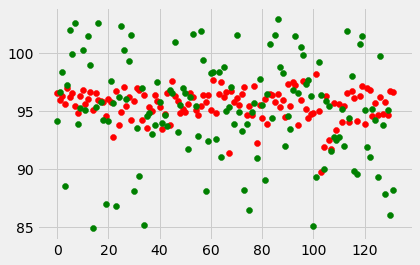

<Figure size 432x288 with 0 Axes>

In [249]:
plt.scatter(range(y_test.shape[0]), results.reshape(results.shape[0]), c='r')
plt.scatter(range(y_test.shape[0]), y_test, c='g')
plt.show()
plt.savefig("share_LSTM.png",transparent=True)

# Attempting to predict Revenue

In [130]:
rev = pd.read_excel("us revenue.xlsx")
rev = rev.T[2:].reset_index()
rev.columns=['Quarter','Revenue']
rev

,Quarter,Revenue
0,3Q12,2256.5
1,4Q12,2212.6
2,1Q13,2088.5
3,2Q13,2282.4
4,3Q13,2289.0
5,4Q13,2191.4
6,1Q14,2054.1
7,2Q14,2249.0
8,3Q14,2202.1
9,4Q14,2145.8


In [132]:
#We transpose our daily credit card data clustering them by their associated quarter
#This yields up to 92 features representing the days in the quarter containing the normalised credit card data
#Each row represents a quarter, it's reported revenue and the up to 92 variables for the credit card transaction in that quarter
for j in rev['Quarter']:
    for i in range(len(credit_df2_norm.loc[(credit_df2_norm['QUARTER']==j)]['NORMALIZED_VALUE'])):
        day = 'DAY' + str(i)
        rev.loc[rev['Quarter']==j, day] = credit_df2_norm.loc[(credit_df2_norm['QUARTER']==j)]['NORMALIZED_VALUE'][i]

In [133]:
rev = rev.fillna(0)
rev

,Quarter,Revenue,DAY0,DAY1,DAY2,DAY3,DAY4,DAY5,DAY6,DAY7,...,DAY82,DAY83,DAY84,DAY85,DAY86,DAY87,DAY88,DAY89,DAY90,DAY91
0,3Q12,2256.5,12.628086,9.873168,9.989532,12.055482,11.267148,11.166134,12.759446,12.676002,...,9.810406,12.275564,11.315926,8.862672,8.876511,10.132761,10.667890,11.107411,12.754746,11.995585
1,4Q12,2212.6,9.496529,9.060144,10.178915,11.206718,11.932095,13.166972,12.290156,10.167093,...,11.170541,10.242044,9.266591,12.548088,9.974360,10.032392,9.985363,11.203641,12.057063,10.003677
2,1Q13,2088.5,12.603135,8.309776,8.489387,9.486216,10.287773,10.062366,7.499496,7.727657,...,11.052693,9.175707,9.403638,10.057285,10.847357,11.771705,10.906451,13.526007,0.000000,0.000000
3,2Q13,2282.4,9.616436,8.845298,9.103404,10.326341,10.467477,12.185998,11.214252,8.672213,...,12.681713,12.546076,9.982346,9.712253,10.838157,11.573068,11.642251,12.501012,12.734453,0.000000
4,3Q13,2289.0,10.092984,9.748872,11.077970,13.617677,12.032379,13.145645,13.776780,9.681208,...,12.526250,11.487548,9.015791,9.570477,9.821827,10.776197,11.437605,13.251260,12.868925,9.608084
5,4Q13,2191.4,9.437157,9.358776,9.725891,10.971597,12.889040,12.269619,8.312579,9.110525,...,9.949456,8.898912,8.877020,11.997433,9.645465,10.029212,11.337280,11.681304,10.184535,9.185451
6,1Q14,2054.1,11.991922,8.290032,9.034288,9.999682,9.676571,7.711897,7.876654,8.590932,...,8.865442,9.464564,9.969954,10.790496,11.346940,12.761666,12.564026,9.518857,0.000000,0.000000
7,2Q14,2249.0,9.329079,9.415343,9.961473,11.354537,12.128385,11.511800,8.616240,9.678895,...,12.237708,9.469303,10.193207,10.412028,11.101919,11.620218,12.832391,13.202619,10.496787,0.000000
8,3Q14,2202.1,10.130519,10.020913,10.829385,12.694408,12.753512,13.520842,9.502116,9.561237,...,10.925851,8.205187,8.509020,9.586312,10.188045,10.436463,12.226247,11.364138,8.903623,9.430558
9,4Q14,2145.8,11.431412,11.549281,8.779372,8.765054,9.020872,9.006487,9.605432,9.712686,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Modelling

In [199]:
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from dtreeviz.trees import dtreeviz

In [147]:
X2 = rev.iloc[:,2:].values
Y2 = rev['Revenue'].values
X_train = X2[:-1]
X_test = X2[-1].reshape(1,92)
Y_train = Y2[:-1]
Y_test = Y2[9].reshape(1, -1)

### Linear Regression

In [189]:
LR = LinearRegression()
LR.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [190]:
results_LR = LR.predict(X_test)
print("The predicted value is for 4Q14: ", results_LR[0], "while the real value is: ", Y_test[0][0])
print("The RMSE is: ", mean_squared_error(y_pred=results_LR, y_true=Y_test, squared=False))

The predicted value is:  1989.077262065999 while the real value is:  2145.8
The RMSE is:  156.7227379340011


### Random Forest

In [228]:
#We use Grid Search CV to identify the best hyperparameters and train using cross-validation
RF=RandomForestRegressor(n_jobs=-2, random_state=47)
parameteres_RF = {'n_estimators' : list(range(100,151,10)), 'max_features' : list(range(1,92,10)), 'max_depth': [15, 10 , 5]}
grid_RF = GridSearchCV(RF, param_grid=parameteres_RF, cv=5, verbose=True, n_jobs=-1, scoring=['neg_root_mean_squared_error', 'r2'], refit='neg_root_mean_squared_error')

In [229]:
#Fitting or training the Random Forest
RF_reg=grid_RF.fit(X_train, Y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-2)]: Done 900 out of 900 | elapsed:   39.8s finished


In [230]:
print('The optimal parameters for the RF are:', RF_reg.best_params_, 'with a validation RMSE score of:', -RF_reg.best_score_)

The optimal parameters for the RF are: {'max_depth': 10, 'max_features': 1, 'n_estimators': 100} with a validation RMSE score of: 56.28510997608689


In [231]:
#Predictions
results_RF = RF_reg.predict(X_test)
print("The predicted value is for 4Q14: ", results_RF[0], "while the real value is: ", Y_test[0][0])
print("The RMSE is: ", mean_squared_error(y_pred=results_RF, y_true=Y_test, squared=False))

The predicted value is for 4Q14:  2189.1639999999998 while the real value is:  2145.8
The RMSE is:  43.36399999999958


In [225]:
r2_score(y_pred=results_RF, y_true=Y_test)

C:\Users\ddkya\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [235]:
#Generates a graph of the first decision tree of the forest
RF2=RandomForestRegressor(n_jobs=-2, random_state=47, max_depth=15, max_features=1, n_estimators=100)
RF2=RF2.fit(X_train, Y_train)

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
dot_data = StringIO()
viz = dtreeviz(RF2.estimators_[0], X2, Y2,
               feature_names=[str(i) for i in range(92)],
               title="tree viz")

viz.save("decision_tree_viz.svg")
#viz.view()

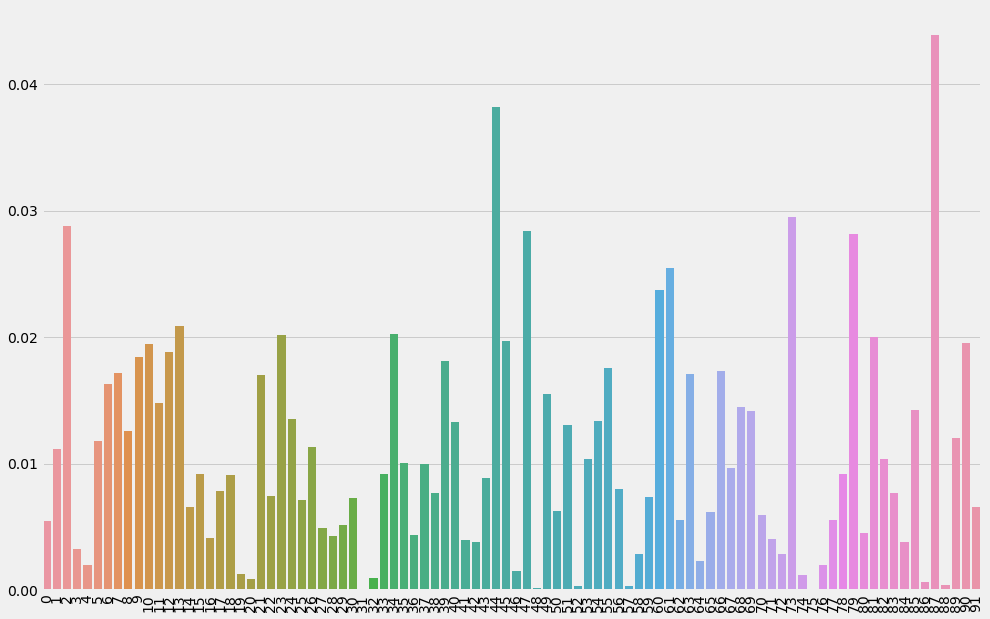

In [250]:
#Importance of each day of a quarter on predicting the associated revenue figure
RD_feat=pd.DataFrame(RF2.feature_importances_).transpose()
RD_feat.columns=rev.iloc[:,2:].columns
plt.figure(figsize=(15,10))
g=sns.barplot(data=RD_feat)
#sns.lineplot(data=RD_feat.T.reset_index(), x='index', y=0)
g.set_xticklabels(rotation=90, labels=range(92))
plt.savefig("RF_feat_imp.png",transparent=True)

### XGBoost 

In [192]:
#We use Grid Search CV to identify the best hyperparameters and train using cross-validation
XGB=XGBRegressor(n_jobs=-1, random_state=47)
parameteres_XGB = {'n_estimators' : list(range(100,200,10))}
grid_XGB = GridSearchCV(XGB, param_grid=parameteres_XGB, cv=5, verbose=True, n_jobs=-1, scoring='neg_root_mean_squared_error')

In [195]:
XGB_reg = grid_XGB.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


In [223]:
print('The optimal parameters for the RF are:', XGB_reg.best_params_, 'with a validation RMSE score of:', -XGB_reg.best_score_)

The optimal parameters for the RF are: {'n_estimators': 100} with a validation RMSE score of: 46.54535998040743


In [197]:
results_XGB = XGB_reg.predict(X_test)
print("The predicted value is for 4Q14: ", results_XGB[0], "while the real value is: ", Y_test[0][0])
print("The RMSE is: ", mean_squared_error(y_pred=results_XGB, y_true=Y_test, squared=False))

The predicted value is:  2201.673 while the real value is:  2145.8
The RMSE is:  55.87309570312482
